# CA4 - Data Science: Convolutional Neural Networks (CNN)

**Course:** Data Science  
**Assignment:** CA4 (Computer Assignment 4)  
**University:** University of Tehran  
**Instructors:** Dr. Bahrak, Dr. Yaghoobzadeh  

**Authors:**

- Mahdy Mokhtari  
- Alborz Mahmoudian  
- Niloufar Mortazavi  

---

### Introduction

This notebook focuses on the **second task** of the assignment: implementing **Convolutional Neural Networks (CNNs)** for **flower image classification**.

The objective is to compare two approaches:
- A custom-built **VGG-style CNN from scratch**.
- A **fine-tuned pretrained ResNet50** model.

The steps include:
- Loading and preprocessing the **Flowers Multiclass Dataset**.
- Applying **data augmentation** to improve generalization.
- Training a VGG-style CNN and evaluating it.
- Fine-tuning a pretrained ResNet50 in multiple phases.
- Comparing performance metrics such as accuracy, precision, recall, F1-score, and AUC across both models.

We utilize **PyTorch** for model development, training, and evaluation.  
The experiments are conducted with GPU acceleration where available (e.g., Google Colab).


In [1]:
# pip install torchvision

In [2]:
# pip install kagglehub

## 1. Dataset Loading

We use the **Flowers Multiclass Dataset** from Kaggle to train our CNN models.

- The dataset was automatically downloaded using `kagglehub.dataset_download(...)`.
- After downloading, the dataset was already organized into `train`, `valid`, and `test` folders.
- No manual splitting was needed, as the dataset is already pre-divided for training, validation, and testing.

This structure makes it easy to load the dataset directly into PyTorch using `ImageFolder`.


In [3]:
# import kagglehub
# path = kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")
# print("Path to dataset files:", path)

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
from google.colab import drive

In [5]:
# CONFIGURATION
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/ML_Datasets/flowers/flower_photos"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

BATCH_SIZE = 32

Mounted at /content/drive


## 2. Image Preprocessing

To prepare the flower images for CNN training:

- **Resize**: All images are resized to **224×224** pixels to match the input size expected by VGG and ResNet.
- **Normalize**: Pixel values are scaled to the [0, 1] range by dividing by 255.
- **Labels**: Two encoding strategies can be used:
  - **Label encoding** (e.g., 0, 1, 2...) — used with `CrossEntropyLoss`.
  - **One-hot encoding** (e.g., [0, 0, 1, 0]) — used with `BCEWithLogitsLoss` for multi-label tasks.

We ensure the label format is compatible with the loss function chosen.


#### Dataset Folder Structure (ImageFolder)

The `test` folder is correctly structured for use with `torchvision.datasets.ImageFolder`.  
It contains one subfolder per flower class:


When using `ImageFolder`, PyTorch:
- Automatically treats each subfolder as a separate class.
- Applies **label encoding** based on **alphabetical order**:
  - `daisy → 0`
  - `dandelion → 1`
  - `roses → 2`
  - `sunflowers → 3`
  - `tulips → 4`

This encoding works seamlessly with `CrossEntropyLoss`, which expects class indices.  
The same logic applies to the `train` and `validation` folders as well.


#### Normalization

Normalization is an essential preprocessing step that scales image pixel values to a standard range expected by deep learning models.

For VGG-style models (and many CNNs trained on ImageNet), we normalize each color channel (Red, Green, Blue) using the **ImageNet mean and standard deviation**:

- **Mean**: `[0.485, 0.456, 0.406]`  
- **Standard Deviation**: `[0.229, 0.224, 0.225]`

This transformation:
- Centers the pixel values around 0
- Ensures consistent variance across channels
- Helps the model converge faster and generalize better


In [6]:
transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # Converts image to tensor and scales to [0,1]
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # ImageNet mean
    std=[0.229, 0.224, 0.225]    # ImageNet std
)
])

train_dataset_basic = datasets.ImageFolder(train_dir, transform=transform_basic)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_basic)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_basic)

# train_loader = DataLoader(train_dataset_basic, batch_size=BATCH_SIZE, shuffle=True)    later on I called the loader
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset_basic)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset_basic.classes}")

Train samples: 3540
Validation samples: 80
Test samples: 50
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


We chose **label encoding** but the below function is for one-hot encoding if needed.

In [7]:
def one_hot_encode(labels, num_classes):
    """
    Convert label-encoded tensor to one-hot tensor.
    Args:
        labels: Tensor of shape [batch_size] with integer labels
        num_classes: Total number of classes
    Returns:
        One-hot encoded tensor of shape [batch_size, num_classes]
    """
    return F.one_hot(labels, num_classes=num_classes).float()

# Example usage (assuming labels from a batch)
# for images, labels in train_loader:
#     one_hot_labels = one_hot_encode(labels, num_classes=len(train_dataset.classes))
#     break  # just for test

print("Labels are prepared using label encoding.")


Labels are prepared using label encoding.


## 3. Data Augmentation

To help the model generalize better and prevent overfitting, we apply data augmentation **only to the training set**.  
Augmentation generates diverse versions of the training images using random transformations like:

- Random rotations between -20° and 20°
- Horizontal flips with 50% probability
- Random crops or shifts (e.g., 10% of image area)
- Slight changes in brightness or contrast

These techniques simulate real-world variations and improve the model's robustness on unseen images.


In [8]:
# Individual augmentations
transform_rotation = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # ImageNet mean
    std=[0.229, 0.224, 0.225]    # ImageNet std
)
])
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])
transform_crop = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])
transform_brightness = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])
transform_combined = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

train_dataset_rotated = datasets.ImageFolder(train_dir, transform=transform_rotation)
train_dataset_flipped = datasets.ImageFolder(train_dir, transform=transform_flip)
train_dataset_cropped = datasets.ImageFolder(train_dir, transform=transform_crop)
train_dataset_bright = datasets.ImageFolder(train_dir, transform=transform_brightness)
train_dataset_combined = datasets.ImageFolder(train_dir, transform=transform_combined)

# Combine all train datasets
train_dataset = ConcatDataset([
    train_dataset_basic,
    # train_dataset_basic,    ######################## If my model overfits I will remove this
    # train_dataset_rotated,
    # train_dataset_flipped,
    # train_dataset_cropped,
    # train_dataset_bright,
    train_dataset_combined
])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


I will print the length of the dataset and as we can see it got twice the big of the original becuase of adding the augmentated images to the train dataset as well.

In [9]:
print("The nth times the dataset got bigger after augmentation: ", len(train_dataset) / len(train_dataset_basic))
print("Total dataset length: ", len(train_dataset))
print(train_dataset_combined.class_to_idx)

The nth times the dataset got bigger after augmentation:  2.0
Total dataset length:  7080
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


## 4. Building a VGG-style CNN from Scratch

In this step, we build and train a **VGG-inspired Convolutional Neural Network (CNN)** to classify flower species.

- **VGG Basics**: A VGG network is composed of multiple stacked convolutional layers with 3×3 filters, followed by max-pooling layers to reduce spatial dimensions.
- At the end, fully connected (dense) layers are used to perform classification.
- We define a simplified VGG-style architecture suitable for the flower dataset and train it using the preprocessed and augmented images.
- The model is evaluated using the validation set to monitor generalization and avoid overfitting.


In [10]:
class VGGFlowerCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGFlowerCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model
vgg_model = VGGFlowerCNN(num_classes=5)
print(vgg_model)


VGGFlowerCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

Now lets train the VGG16 CNN Model.

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)
print("device: ", device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.0001)

num_epochs = 15

device:  cuda


In [12]:
# Training loop
for epoch in range(num_epochs):
    vgg_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = vgg_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Validation loop
vgg_model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_model(images)
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/15: 100%|██████████| 222/222 [31:53<00:00,  8.62s/it]


Epoch [1/15], Loss: 318.7006, Train Accuracy: 34.34%


Epoch 2/15: 100%|██████████| 222/222 [02:21<00:00,  1.56it/s]


Epoch [2/15], Loss: 262.4966, Train Accuracy: 48.33%


Epoch 3/15: 100%|██████████| 222/222 [02:22<00:00,  1.56it/s]


Epoch [3/15], Loss: 229.1024, Train Accuracy: 58.36%


Epoch 4/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [4/15], Loss: 191.8402, Train Accuracy: 66.57%


Epoch 5/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [5/15], Loss: 166.8427, Train Accuracy: 71.47%


Epoch 6/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [6/15], Loss: 156.3652, Train Accuracy: 72.98%


Epoch 7/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [7/15], Loss: 143.4294, Train Accuracy: 75.07%


Epoch 8/15: 100%|██████████| 222/222 [02:22<00:00,  1.56it/s]


Epoch [8/15], Loss: 128.8005, Train Accuracy: 78.02%


Epoch 9/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [9/15], Loss: 120.5526, Train Accuracy: 79.56%


Epoch 10/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [10/15], Loss: 104.7150, Train Accuracy: 82.03%


Epoch 11/15: 100%|██████████| 222/222 [02:20<00:00,  1.58it/s]


Epoch [11/15], Loss: 99.0359, Train Accuracy: 83.33%


Epoch 12/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [12/15], Loss: 85.1334, Train Accuracy: 86.48%


Epoch 13/15: 100%|██████████| 222/222 [02:22<00:00,  1.56it/s]


Epoch [13/15], Loss: 74.4432, Train Accuracy: 88.11%


Epoch 14/15: 100%|██████████| 222/222 [02:22<00:00,  1.56it/s]


Epoch [14/15], Loss: 68.4235, Train Accuracy: 89.19%


Epoch 15/15: 100%|██████████| 222/222 [02:21<00:00,  1.57it/s]


Epoch [15/15], Loss: 61.9523, Train Accuracy: 90.41%
Validation Accuracy: 82.50%


## 5. Fine-Tuning a Pretrained ResNet

In this section, we will fine-tune a pretrained ResNet model (e.g., ResNet50) to classify flower images. This transfer learning process helps achieve high accuracy even with limited data.

Steps:
- **Setup**: Load a pretrained ResNet50 from `torchvision.models`.
- **Freeze Base, Train Head**: Freeze all convolutional layers and replace the final classification head with a new one for our flower classes. Train for 5–10 epochs.
- **Unfreeze Last Conv Layer**: Gradually unfreeze the last convolutional block (e.g., `layer4`) and train with the head for another 5–10 epochs to adapt mid-level features.
- **Unfreeze All**: Finally, unfreeze the entire model and fine-tune it end-to-end for another 5–10 epochs.
- **Evaluate** after each stage to measure improvements in validation accuracy.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torchvision.models import ResNet50_Weights

# Load pretrained ResNet50
resnet_model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)  # 5 flower classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [19]:
NUM_EPOCHS = 7
LR = 0.001

# ------- Stage 1: Freeze all except final layer -------
for param in resnet_model.parameters():
    param.requires_grad = False

for param in resnet_model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(resnet_model.fc.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    resnet_model.train()
    correct = total = 0
    for images, labels in tqdm(train_loader, desc=f"[Stage 1] Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    print(f"Stage 1 Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%")


[Stage 1] Epoch 1/7: 100%|██████████| 222/222 [01:18<00:00,  2.82it/s]


Stage 1 Epoch 1, Accuracy: 84.56%


[Stage 1] Epoch 2/7: 100%|██████████| 222/222 [01:15<00:00,  2.94it/s]


Stage 1 Epoch 2, Accuracy: 91.92%


[Stage 1] Epoch 3/7: 100%|██████████| 222/222 [01:16<00:00,  2.91it/s]


Stage 1 Epoch 3, Accuracy: 93.95%


[Stage 1] Epoch 4/7: 100%|██████████| 222/222 [01:16<00:00,  2.91it/s]


Stage 1 Epoch 4, Accuracy: 94.41%


[Stage 1] Epoch 5/7: 100%|██████████| 222/222 [01:14<00:00,  2.99it/s]


Stage 1 Epoch 5, Accuracy: 95.30%


[Stage 1] Epoch 6/7: 100%|██████████| 222/222 [01:13<00:00,  3.02it/s]


Stage 1 Epoch 6, Accuracy: 96.26%


[Stage 1] Epoch 7/7: 100%|██████████| 222/222 [01:14<00:00,  3.00it/s]

Stage 1 Epoch 7, Accuracy: 96.45%


In [20]:
NUM_EPOCHS = 7
LR = 0.0001

# ------- Stage 2: Unfreeze layer4 + fc -------
for name, param in resnet_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define optimizer only for parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=LR)

# Training loop
for epoch in range(NUM_EPOCHS):
    resnet_model.train()
    correct = total = 0
    for images, labels in tqdm(train_loader, desc=f"[Stage 2] Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Stage 2 Epoch {epoch+1}, Accuracy: {accuracy:.2f}%")


[Stage 2] Epoch 1/7: 100%|██████████| 222/222 [01:21<00:00,  2.74it/s]


Stage 2 Epoch 1, Accuracy: 97.33%


[Stage 2] Epoch 2/7: 100%|██████████| 222/222 [01:24<00:00,  2.64it/s]


Stage 2 Epoch 2, Accuracy: 99.38%


[Stage 2] Epoch 3/7: 100%|██████████| 222/222 [01:25<00:00,  2.61it/s]


Stage 2 Epoch 3, Accuracy: 99.49%


[Stage 2] Epoch 4/7: 100%|██████████| 222/222 [01:21<00:00,  2.71it/s]


Stage 2 Epoch 4, Accuracy: 99.79%


[Stage 2] Epoch 5/7: 100%|██████████| 222/222 [01:21<00:00,  2.73it/s]


Stage 2 Epoch 5, Accuracy: 99.70%


[Stage 2] Epoch 6/7: 100%|██████████| 222/222 [01:23<00:00,  2.67it/s]


Stage 2 Epoch 6, Accuracy: 99.77%


[Stage 2] Epoch 7/7: 100%|██████████| 222/222 [01:22<00:00,  2.70it/s]

Stage 2 Epoch 7, Accuracy: 99.84%


In [21]:
NUM_EPOCHS = 7
LR = 0.00001

# ------- Stage 3: Unfreeze all layers -------
for param in resnet_model.parameters():
    param.requires_grad = True

# Optimizer over all parameters
optimizer = optim.Adam(resnet_model.parameters(), lr=LR)

# Training loop
for epoch in range(NUM_EPOCHS):
    resnet_model.train()
    correct = total = 0
    for images, labels in tqdm(train_loader, desc=f"[Stage 3] Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Stage 3 Epoch {epoch+1}, Accuracy: {accuracy:.2f}%")


[Stage 3] Epoch 1/7: 100%|██████████| 222/222 [01:59<00:00,  1.86it/s]


Stage 3 Epoch 1, Accuracy: 99.87%


[Stage 3] Epoch 2/7: 100%|██████████| 222/222 [02:02<00:00,  1.81it/s]


Stage 3 Epoch 2, Accuracy: 99.93%


[Stage 3] Epoch 3/7: 100%|██████████| 222/222 [01:59<00:00,  1.85it/s]


Stage 3 Epoch 3, Accuracy: 99.90%


[Stage 3] Epoch 4/7: 100%|██████████| 222/222 [02:02<00:00,  1.81it/s]


Stage 3 Epoch 4, Accuracy: 99.93%


[Stage 3] Epoch 5/7: 100%|██████████| 222/222 [02:00<00:00,  1.85it/s]


Stage 3 Epoch 5, Accuracy: 99.94%


[Stage 3] Epoch 6/7: 100%|██████████| 222/222 [02:01<00:00,  1.83it/s]


Stage 3 Epoch 6, Accuracy: 99.94%


[Stage 3] Epoch 7/7: 100%|██████████| 222/222 [02:00<00:00,  1.84it/s]

Stage 3 Epoch 7, Accuracy: 99.97%


In [22]:
# ------- Evaluation on Validation Set -------
resnet_model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, preds = outputs.max(1)
        val_total += labels.size(0)
        val_correct += preds.eq(labels).sum().item()
print(f"Final Validation Accuracy: {100 * val_correct / val_total:.2f}%")

Final Validation Accuracy: 95.00%


## 6. Result Comparison: VGG vs. ResNet

In this step, we conduct a fair and thorough evaluation of the custom VGG model and the fine-tuned ResNet50 model. We compare their classification performance using key metrics:

- **Accuracy**: Overall correct predictions.
- **Precision, Recall, and F1-Score**: Per-class performance.
- **Confusion Matrix**: Visual representation of classification errors.
- **ROC Curve & AUC Score**: Diagnostic capability and robustness (especially useful for multi-class classification via one-vs-rest strategy).

These metrics provide deeper insight into each model’s strengths, weaknesses, and generalization ability on the validation dataset.


In [25]:
import numpy as np


def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)



# 1. Get predictions
y_true_vgg, y_pred_vgg = get_predictions(vgg_model, test_loader, device)
y_true_resnet, y_pred_resnet = get_predictions(resnet_model, test_loader, device)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compare_classification_metrics(y_true1, y_pred1, y_true2, y_pred2, name1="VGG", name2="ResNet"):
    print(f"{'Metric':<10} | {name1:<10} | {name2:<10}")
    print("-" * 35)
    for metric_name, func in {
        "Accuracy": accuracy_score,
        "Precision": lambda y, p: precision_score(y, p, average='macro'),
        "Recall": lambda y, p: recall_score(y, p, average='macro'),
        "F1-Score": lambda y, p: f1_score(y, p, average='macro'),
    }.items():
        v1 = func(y_true1, y_pred1)
        v2 = func(y_true2, y_pred2)
        print(f"{metric_name:<10} | {v1:.4f}     | {v2:.4f}")



# 2. Compare classification metrics
compare_classification_metrics(y_true_vgg, y_pred_vgg, y_true_resnet, y_pred_resnet)

Metric     | VGG        | ResNet    
-----------------------------------
Accuracy   | 0.6600     | 0.9400
Precision  | 0.7157     | 0.9396
Recall     | 0.6600     | 0.9400
F1-Score   | 0.6541     | 0.9389


### Why ResNet Performed Better Than VGG in Performance Metrics

The ResNet model achieved significantly higher scores in all evaluation metrics compared to the VGG model. This performance gap can be explained by several important factors:

1. **Deeper Architecture with Skip Connections**  
   ResNet50 is a much deeper network (50 layers) compared to VGG, yet it remains trainable due to its residual (skip) connections. These connections help mitigate issues like vanishing gradients and allow the model to learn complex features more effectively.

2. **Pretraining on ImageNet**  
   ResNet50 was initialized with pretrained weights from ImageNet. This gave the model a strong foundation of learned features that are transferable to the flower classification task. On the other hand, VGG was trained from scratch and had to learn all patterns from the dataset without prior knowledge.

3. **Effective Fine-Tuning Strategy**  
   The ResNet model was fine-tuned in stages—first training only the classifier head, then unfreezing the last convolutional block, and finally training the entire network. This gradual adaptation allowed the model to adjust to the new data while preserving useful pretrained features.

4. **Better Feature Reuse and Regularization**  
   The architecture of ResNet inherently encourages feature reuse through its skip connections, which also act as a form of regularization. This results in better generalization to unseen data, reducing overfitting compared to VGG.




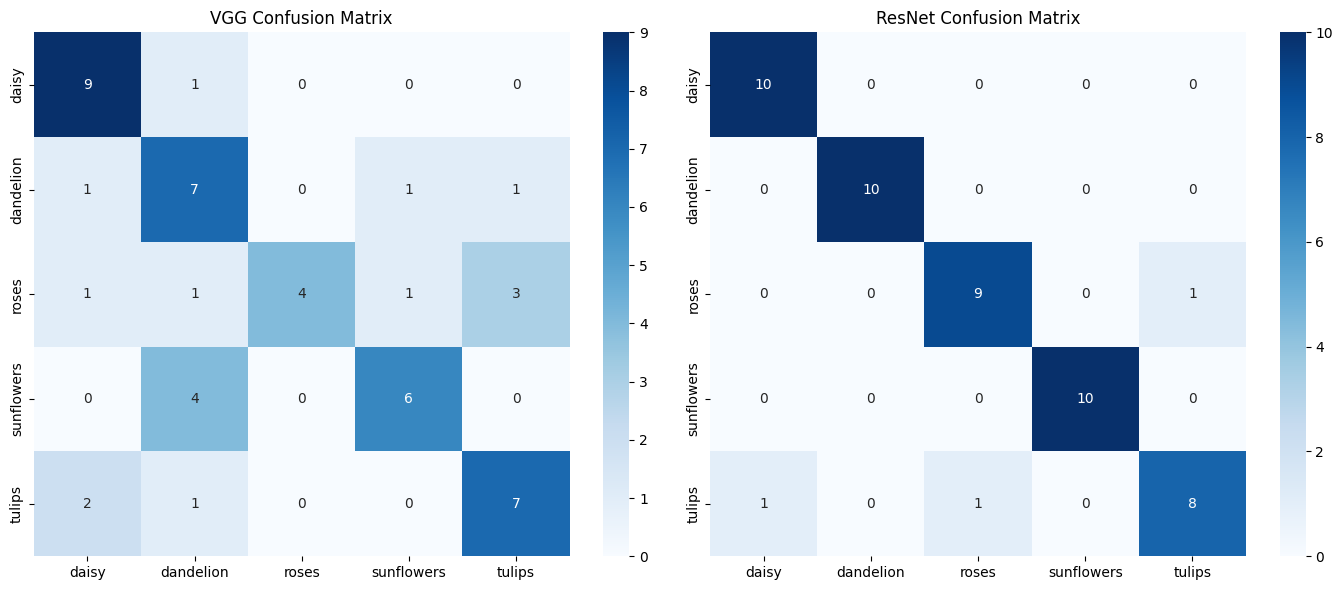

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compare_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, class_names, name1="VGG", name2="ResNet"):
    cm1 = confusion_matrix(y_true1, y_pred1)
    cm2 = confusion_matrix(y_true2, y_pred2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title(f"{name1} Confusion Matrix")

    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title(f"{name2} Confusion Matrix")

    plt.tight_layout()
    plt.show()




# 3. Confusion matrix
compare_confusion_matrices(y_true_vgg, y_pred_vgg, y_true_resnet, y_pred_resnet, class_names=train_dataset_basic.classes)


### Confusion Matrix Analysis: VGG vs. ResNet

The **confusion matrix** is a powerful tool for visualizing classification performance by showing how many instances were correctly or incorrectly predicted for each class.

- **Rows** represent the actual flower classes.
- **Columns** represent the predicted flower classes.
- The diagonal elements indicate correct predictions.
- Off-diagonal elements represent misclassifications.


The VGG confusion matrix

Shows that while the model performs reasonably well, it struggles with several misclassifications. For instance, roses are often confused with sunflowers and dandelions, and sunflowers are misclassified as dandelions multiple times. These errors suggest that the VGG model has difficulty capturing distinct class-specific features, leading to overlap in its predictions across similar flower types.


ResNet Confusion Matrix:

The ResNet model shows significantly better performance with most predictions correctly placed along the diagonal.

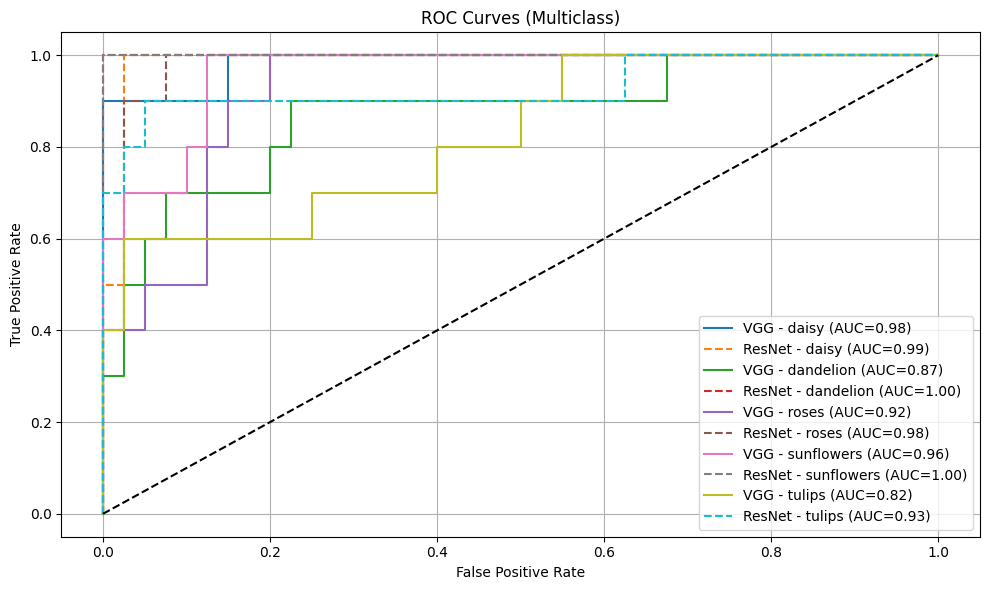

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve

def compare_roc_auc(model1, model2, dataloader, device, class_names, name1="VGG", name2="ResNet"):
    def get_probs_and_labels(model):
        model.eval()
        all_probs = []
        all_labels = []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                outputs = model(images)
                all_probs.append(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        return np.vstack(all_probs), np.array(all_labels)

    probs1, labels1 = get_probs_and_labels(model1)
    probs2, labels2 = get_probs_and_labels(model2)

    bin_labels1 = label_binarize(labels1, classes=range(len(class_names)))
    bin_labels2 = label_binarize(labels2, classes=range(len(class_names)))

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(class_names):
        fpr1, tpr1, _ = roc_curve(bin_labels1[:, i], probs1[:, i])
        auc1 = roc_auc_score(bin_labels1[:, i], probs1[:, i])
        plt.plot(fpr1, tpr1, label=f"{name1} - {class_name} (AUC={auc1:.2f})")

        fpr2, tpr2, _ = roc_curve(bin_labels2[:, i], probs2[:, i])
        auc2 = roc_auc_score(bin_labels2[:, i], probs2[:, i])
        plt.plot(fpr2, tpr2, linestyle='--', label=f"{name2} - {class_name} (AUC={auc2:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curves (Multiclass)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 4. ROC & AUC
compare_roc_auc(vgg_model, resnet_model, test_loader, device, class_names=train_dataset_basic.classes)


### ROC Curve (Multiclass) and AUC Analysis

The ROC (Receiver Operating Characteristic) curve is a diagnostic tool used to visualize the performance of classification models. It plots the True Positive Rate (Sensitivity) against the False Positive Rate for different threshold settings. For multiclass problems, one curve is plotted per class using the one-vs-rest strategy. The AUC (Area Under the Curve) represents the model's ability to distinguish between classes — the closer to 1, the better.

In the figure above, the ResNet model consistently outperforms the VGG model across all flower classes. ResNet achieves nearly perfect AUC values (close to or exactly 1.00), while the VGG model shows relatively lower performance, especially for classes like tulips and dandelions. This clearly illustrates the stronger generalization and discriminative power of the fine-tuned ResNet compared to the VGG model.
